In [ ]:
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_


Training PPO with Base uncertainty:
Episode 0, Reward: 16.00
Episode 1, Reward: 29.00
Episode 2, Reward: 49.00
Episode 3, Reward: 16.00
Episode 4, Reward: 33.00
Episode 5, Reward: 30.00
Episode 6, Reward: 21.00
Episode 7, Reward: 20.00
Episode 8, Reward: 23.00
Episode 9, Reward: 19.00
Episode 10, Reward: 12.00
Episode 11, Reward: 15.00
Episode 12, Reward: 15.00
Episode 13, Reward: 15.00
Episode 14, Reward: 25.00
Episode 15, Reward: 44.00
Episode 16, Reward: 34.00
Episode 17, Reward: 16.00
Episode 18, Reward: 11.00
Episode 19, Reward: 24.00
Episode 20, Reward: 27.00
Episode 21, Reward: 16.00
Episode 22, Reward: 25.00
Episode 23, Reward: 30.00
Episode 24, Reward: 16.00
Episode 25, Reward: 17.00
Episode 26, Reward: 38.00
Episode 27, Reward: 16.00
Episode 28, Reward: 31.00
Episode 29, Reward: 51.00
Episode 30, Reward: 24.00
Episode 31, Reward: 26.00
Episode 32, Reward: 26.00
Episode 33, Reward: 24.00
Episode 34, Reward: 39.00
Episode 35, Reward: 14.00
Episode 36, Reward: 28.00
Episode 37,

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning:

WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.



Episode 12, Reward: 28.00
Episode 13, Reward: 31.00
Episode 14, Reward: 21.00
Episode 15, Reward: 16.00
Episode 16, Reward: 18.00
Episode 17, Reward: 14.00
Episode 18, Reward: 14.00
Episode 19, Reward: 66.00
Episode 20, Reward: 13.00
Episode 21, Reward: 10.00
Episode 22, Reward: 11.00
Episode 23, Reward: 44.00
Episode 24, Reward: 17.00
Episode 25, Reward: 25.00
Episode 26, Reward: 46.00
Episode 27, Reward: 14.00
Episode 28, Reward: 32.00
Episode 29, Reward: 16.00
Episode 30, Reward: 17.00
Episode 31, Reward: 16.00
Episode 32, Reward: 20.00
Episode 33, Reward: 11.00
Episode 34, Reward: 28.00
Episode 35, Reward: 12.00
Episode 36, Reward: 19.00
Episode 37, Reward: 13.00
Episode 38, Reward: 11.00
Episode 39, Reward: 9.00
Episode 40, Reward: 22.00
Episode 41, Reward: 19.00
Episode 42, Reward: 18.00
Episode 43, Reward: 17.00
Episode 44, Reward: 10.00
Episode 45, Reward: 31.00
Episode 46, Reward: 14.00
Episode 47, Reward: 14.00
Episode 48, Reward: 12.00
Episode 49, Reward: 18.00
Episode 50, R

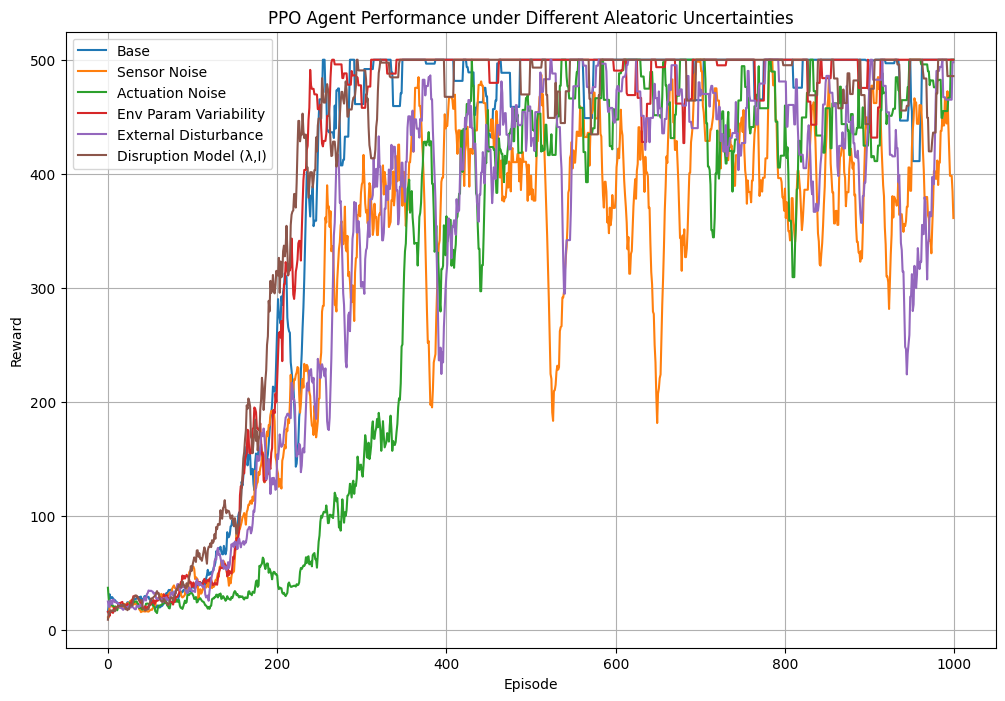

In [ ]:
import gym
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from collections import deque
import matplotlib.pyplot as plt

# ------------------------------
# 1. Define the PPO components
# ------------------------------

class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorCritic, self).__init__()
        # Shared feature extractor
        self.fc1 = nn.Linear(state_dim, 64)

        # Actor (policy) network
        self.actor_fc = nn.Linear(64, 64)
        self.actor_out = nn.Linear(64, action_dim)

        # Critic (value) network
        self.critic_fc = nn.Linear(64, 64)
        self.critic_out = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))

        # Actor: compute action probabilities
        actor_x = F.relu(self.actor_fc(x))
        action_probs = F.softmax(self.actor_out(actor_x), dim=-1)

        # Critic: compute state value
        critic_x = F.relu(self.critic_fc(x))
        state_value = self.critic_out(critic_x)

        return action_probs, state_value

    def act(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)
        action_probs, _ = self(state)
        dist = Categorical(action_probs)
        action = dist.sample()
        action_log_prob = dist.log_prob(action)
        return action.item(), action_log_prob

    def evaluate(self, states, actions):
        action_probs, state_values = self(states)
        dist = Categorical(action_probs)
        action_log_probs = dist.log_prob(actions)
        entropy = dist.entropy()
        return action_log_probs, state_values, entropy

# Memory buffer for PPO
class PPOMemory:
    def __init__(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.next_states = []
        self.action_log_probs = []
        self.dones = []

    def push(self, state, action, reward, next_state, action_log_prob, done):
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        self.next_states.append(next_state)
        self.action_log_probs.append(action_log_prob)
        self.dones.append(done)

    def clear(self):
        self.states.clear()
        self.actions.clear()
        self.rewards.clear()
        self.next_states.clear()
        self.action_log_probs.clear()
        self.dones.clear()

    def __len__(self):
        return len(self.states)

# -----------------------------------
# 2. Define wrappers for uncertainties (unchanged from your code)
# -----------------------------------

# 2.1 Sensor/Observation Noise
class SensorNoiseWrapper(gym.ObservationWrapper):
    def __init__(self, env, noise_std=0.1):
        super(SensorNoiseWrapper, self).__init__(env)
        self.noise_std = noise_std

    def observation(self, observation):
        noise = np.random.normal(0, self.noise_std, size=observation.shape)
        return observation + noise

# 2.2 Actuation/Control Noise
class ActuationNoiseWrapper(gym.ActionWrapper):
    def __init__(self, env, flip_prob=0.1):
        super(ActuationNoiseWrapper, self).__init__(env)
        self.flip_prob = flip_prob

    def action(self, action):
        if np.random.rand() < self.flip_prob:
            return 1 - action  # For CartPole, actions are 0 or 1.
        return action

# 2.3 Environmental Parameter Variability
class EnvParamVariabilityWrapper(gym.Wrapper):
    def __init__(self, env, extra_mass_range=(0.0, 0.2)):
        super(EnvParamVariabilityWrapper, self).__init__(env)
        self.extra_mass_range = extra_mass_range
        # Get base values from the environment (fallback to known defaults)
        self.base_masspole = env.env.masspole if hasattr(env.env, 'masspole') else 0.1
        self.base_masscart = env.env.masscart if hasattr(env.env, 'masscart') else 1.0
        self.base_length = env.env.length if hasattr(env.env, 'length') else 0.5

    def reset(self, **kwargs):
        observation = self.env.reset(**kwargs)
        extra_mass = np.random.uniform(*self.extra_mass_range)
        if hasattr(self.env.env, 'masspole'):
            self.env.env.masspole = self.base_masspole + extra_mass
            self.env.env.total_mass = self.env.env.masspole + self.base_masscart
            self.env.env.polemass_length = self.env.env.masspole * self.base_length
        return observation

# 2.4 External Disturbances
class ExternalDisturbanceWrapper(gym.Wrapper):
    def __init__(self, env, wind_amplitude=1.0, wind_frequency=0.1):
        super(ExternalDisturbanceWrapper, self).__init__(env)
        self.wind_amplitude = wind_amplitude
        self.wind_frequency = wind_frequency
        self.step_count = 0

    def reset(self, **kwargs):
        self.step_count = 0
        return self.env.reset(**kwargs)

    def step(self, action):
        result = self.env.step(action)
        # Handle new/old step API return formats.
        if len(result) == 5:
            obs, reward, done, truncated, info = result
            done = done or truncated
        else:
            obs, reward, done, info = result

        # Compute wind force as a sinusoidal function.
        wind = self.wind_amplitude * np.sin(self.wind_frequency * self.step_count)
        self.step_count += 1

        # Modify the observation: add wind to the cart's velocity (index 1)
        obs_modified = obs.copy()
        obs_modified[1] += wind

        # Update the underlying state if possible.
        if hasattr(self.env.env, 'state'):
            if isinstance(self.env.env.state, tuple):
                state_list = list(self.env.env.state)
                state_list[1] += wind
                self.env.env.state = tuple(state_list)
            else:
                self.env.env.state[1] += wind

        return obs_modified, reward, done, info

# 2.5 Unified Aleatoric Disruption
class DisruptionWrapper(gym.Wrapper):
    def __init__(self, env, lambda_rate=0.1, intensity_vector=None):
        super(DisruptionWrapper, self).__init__(env)
        self.lambda_rate = lambda_rate
        self.intensity_vector = np.array(intensity_vector) if intensity_vector is not None else np.zeros(env.observation_space.shape[0])

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

    def step(self, action):
        result = self.env.step(action)
        if len(result) == 5:
            obs, reward, done, truncated, info = result
            done = done or truncated
        else:
            obs, reward, done, info = result

        # Apply disruption with probability λ
        if np.random.rand() < self.lambda_rate:
            noise = np.random.uniform(-self.intensity_vector, self.intensity_vector)
            obs = obs + noise
            # (Optional) Modify underlying env state if applicable
            if hasattr(self.env.env, 'state'):
                self.env.env.state = np.array(self.env.env.state) + noise

        return obs, reward, done, info

# -----------------------------------------
# 3. Training function for the PPO agent
# -----------------------------------------

def compute_gae(rewards, values, dones, next_value, gamma=0.99, tau=0.95):
    """Compute Generalized Advantage Estimation"""
    advantages = []
    gae = 0
    for i in reversed(range(len(rewards))):
        if i == len(rewards) - 1:
            next_val = next_value
        else:
            next_val = values[i + 1]

        delta = rewards[i] + gamma * next_val * (1 - dones[i]) - values[i]
        gae = delta + gamma * tau * (1 - dones[i]) * gae
        advantages.insert(0, gae)

    advantages = torch.tensor(advantages, dtype=torch.float32)
    returns = advantages + torch.tensor(values, dtype=torch.float32)
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    return advantages, returns

def train_ppo(env_fn, episodes=200, update_timestep=1000, eps_clip=0.2, gamma=0.99,
              lr=3e-4, ppo_epochs=10, mini_batch_size=64, entropy_coef=0.01, value_coef=0.5):
    env = env_fn()
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    policy = ActorCritic(state_dim, action_dim)
    optimizer = optim.Adam(policy.parameters(), lr=lr)
    memory = PPOMemory()

    timestep = 0
    rewards_history = []

    for episode in range(episodes):
        state = env.reset()
        done = False
        episode_reward = 0

        while not done:
            timestep += 1

            # Select action
            action, action_log_prob = policy.act(state)

            # Take the action
            step_result = env.step(action)
            if len(step_result) == 5:
                next_state, reward, done, truncated, _ = step_result
                done = done or truncated
            else:
                next_state, reward, done, _ = step_result

            # Store experience
            memory.push(state, action, reward, next_state, action_log_prob, done)

            state = next_state
            episode_reward += reward

            # Update policy if enough data is collected
            if timestep % update_timestep == 0:
                # Calculate state values
                states = torch.FloatTensor(memory.states)
                _, values = policy(states)
                values = values.squeeze().detach().numpy().tolist()

                # If the episode is not done, estimate the value of the last state
                if not done:
                    next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)
                    _, next_value = policy(next_state_tensor)
                    next_value = next_value.item()
                else:
                    next_value = 0

                # Calculate advantages and returns
                advantages, returns = compute_gae(
                    memory.rewards, values, memory.dones, next_value, gamma
                )

                # Convert memory to tensors
                states = torch.FloatTensor(memory.states)
                actions = torch.LongTensor(memory.actions)
                old_log_probs = torch.FloatTensor(memory.action_log_probs)

                # PPO update
                for _ in range(ppo_epochs):
                    # Create mini-batches
                    indices = np.random.permutation(len(memory))
                    for start_idx in range(0, len(memory), mini_batch_size):
                        idx = indices[start_idx:start_idx + mini_batch_size]

                        # Sample data for mini-batch
                        batch_states = states[idx]
                        batch_actions = actions[idx]
                        batch_advantages = advantages[idx]
                        batch_returns = returns[idx]
                        batch_old_log_probs = old_log_probs[idx]

                        # Evaluate actions and values
                        log_probs, values, entropy = policy.evaluate(batch_states, batch_actions)
                        values = values.squeeze()

                        # Compute ratio and clipped ratio
                        ratios = torch.exp(log_probs - batch_old_log_probs)
                        surr1 = ratios * batch_advantages
                        surr2 = torch.clamp(ratios, 1.0 - eps_clip, 1.0 + eps_clip) * batch_advantages

                        # Compute actor and critic losses
                        actor_loss = -torch.min(surr1, surr2).mean()
                        critic_loss = F.mse_loss(values, batch_returns)
                        entropy_loss = -entropy.mean()

                        # Compute total loss
                        loss = actor_loss + value_coef * critic_loss + entropy_coef * entropy_loss

                        # Update network
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # Clear memory after update
                memory.clear()

        rewards_history.append(episode_reward)
        print(f"Episode {episode}, Reward: {episode_reward:.2f}")

    env.close()
    return rewards_history

# ------------------------------------------------------
# 4. Create environment functions for each uncertainty (unchanged)
# ------------------------------------------------------

def make_base_env():
    # Base environment (no uncertainty)
    env = gym.make('CartPole-v1', new_step_api=True)
    return env

def make_sensor_noise_env():
    env = gym.make('CartPole-v1', new_step_api=True)
    env = SensorNoiseWrapper(env, noise_std=0.1)
    return env

def make_actuation_noise_env():
    env = gym.make('CartPole-v1', new_step_api=True)
    env = ActuationNoiseWrapper(env, flip_prob=0.1)
    return env

def make_env_param_variability_env():
    env = gym.make('CartPole-v1', new_step_api=True)
    env = EnvParamVariabilityWrapper(env, extra_mass_range=(0.0, 0.2))
    return env

def make_external_disturbance_env():
    env = gym.make('CartPole-v1', new_step_api=True)
    env = ExternalDisturbanceWrapper(env, wind_amplitude=1.0, wind_frequency=0.1)
    return env

def make_disruption_env():
    env = gym.make('CartPole-v1', new_step_api=True)
    lambda_rate = 0.1
    intensity = [0.05, 0.1, 0.05, 0.1]  # Example disruption scale per dimension
    env = DisruptionWrapper(env, lambda_rate=lambda_rate, intensity_vector=intensity)
    return env

# -------------------------------------------------
# 5. Run experiments and collect performance metrics
# -------------------------------------------------

def run_experiments(episodes=200):
    experiments = {
        "Base": make_base_env,
        "Sensor Noise": make_sensor_noise_env,
        "Actuation Noise": make_actuation_noise_env,
        "Env Param Variability": make_env_param_variability_env,
        "External Disturbance": make_external_disturbance_env,
        "Disruption Model (λ,I)": make_disruption_env
    }

    results = {}

    for key, env_fn in experiments.items():
        print(f"\nTraining PPO with {key} uncertainty:")
        rewards = train_ppo(env_fn, episodes=episodes)
        results[key] = rewards

    return results

# --------------------------------------
# 6. Plot the training performance curves
# --------------------------------------

def plot_results(results):
    plt.figure(figsize=(12, 8))
    for key, rewards in results.items():
        # Smoothing the curve for better visualization
        smoothed_rewards = []
        window_size = 10
        for i in range(len(rewards)):
            window_start = max(0, i - window_size)
            smoothed_rewards.append(np.mean(rewards[window_start:i+1]))

        plt.plot(smoothed_rewards, label=key)

    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("PPO Agent Performance under Different Aleatoric Uncertainties")
    plt.legend()
    plt.grid(True)
    plt.savefig('ppo_uncertainty_results.png')
    plt.show()

# --------------------------------------
# 7. Main function to run all experiments
# --------------------------------------

def main():
    episodes = 1000  # Adjust as needed
    results = run_experiments(episodes)
    plot_results(results)

    # For Plotly visualization (compatible with your code)
    return results

if __name__ == "__main__":
    results = main()

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

for key, rewards in results.items():
    fig.add_trace(
        go.Scatter(
            x=list(range(len(rewards))),
            y=rewards,
            mode='lines',
            name=key
        )
    )

fig.update_layout(
    title="PPO Agent Performance under Different Aleatoric Uncertainties",
    xaxis_title="Episode",
    yaxis_title="Reward",
    template="plotly_white"
)

fig.show()

In [ ]:
import plotly.graph_objects as go

for key, rewards in results.items():
    fig = go.Figure()
    fig.add_trace(
        go.Scatter(
            x=list(range(len(rewards))),
            y=rewards,
            mode='lines',
            name=key
        )
    )
    fig.update_layout(
        title=f"RL Agent Performance - {key}",
        xaxis_title="Episode",
        yaxis_title="Reward",
        template="plotly_white"
    )
    fig.show()

In [ ]:
import plotly.graph_objects as go
import numpy as np

def moving_average(data, window_size=10):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

fig = go.Figure()

for key, rewards in results.items():
    smoothed = moving_average(rewards, window_size=10)

    # Raw rewards (faded for clarity)
    fig.add_trace(
        go.Scatter(
            x=list(range(len(rewards))),
            y=rewards,
            mode='lines',
            name=f"{key} (Raw)",
            opacity=0.3,
            line=dict(dash='dot')
        )
    )

    # Smoothed rewards
    fig.add_trace(
        go.Scatter(
            x=list(range(len(smoothed))),
            y=smoothed,
            mode='lines',
            name=f"{key} (Smoothed)"
        )
    )

fig.update_layout(
    title="RL Agent Performance under Different Aleatoric Uncertainties",
    xaxis_title="Episode",
    yaxis_title="Reward",
    template="plotly_white",
    legend_title="Uncertainty Type"
)

fig.show()